# West Nile Virus analysis: spatial factors and prediction  
## Mid-term draft 
Hanpu Yao  
Professor Jonanthan Tannen



### Proposals: 

**Goal**: find the high risk area of West Nile Virus and allocate pesticide accordingly.  
-	Predict the time and place that WNV may propably present  

**Dataset**:
1.	Main data: mosquitos captured in traps (2007/5 – 2021/9):  
Time,
Location, 
Mosquitoes(number, spiecies, WNV positivity)


2.	Spray Data: spraying pesticide to kill mosquitos (2011/8 – 2013/9 will reach out for more data) 
Time
Location (area)

3.	Weather Data – WNV prefers hot and dry environment: 
Rain, 
Wind, 
Temperature, 
Moisture
		
4.	Bird - Report positive case of dead bird

5.	Urban environment – 311 sanitation report

6.	Natural environment location: Parks, water


**Mid term status:**

wrangling data to visualize and see what is the probable relationship.

**Problem**

1. Spray data only contain one year and City of Chicago didn't reply yet. For now I maybe have to narrow down the time span to that one year. And if they give the whole data then I can add them in and run the same process.
2. There are temperal and spatial factors, so I have to find a proper way to handle this two dimension best.
+ Temperal factors: 
1. Pesticide effect over time
2. Positive cases in past days may affect cases in future days (if no pesticide sprayed)

+ Spatial factors:
1. Distantce to park, lakes, river or dirty place.
2. Wind effect: positive cases in upwind area may affect downwind area.



In [ ]:
!pip install sodapy
!pip install geopandas
!pip install geoplot

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px #
from sodapy import Socrata # api to get data
import missingno as msno # check NAs
import matplotlib.pyplot as plt
import geopandas as gpd
import geoplot as gplt

%matplotlib inline

import warnings
warnings.filterwarnings("ignore") # don't show warnings

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
mapdata = np.loadtxt("/content/drive/MyDrive/Colab Notebooks/Capstone/data/mapdata_copyright_openstreetmap_contributors.txt")


mosquitos data

In [ ]:

# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("data.cityofchicago.org", None)

# Example authenticated client (needed for non-public datasets):
# client = Socrata(data.cityofchicago.org,
#                  MyAppToken,
#                  userame="user@example.com",
#                  password="AFakePassword")

# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("jqe8-8r6s", limit=60000)

# Convert to pandas DataFrame
df_trap_raw = pd.DataFrame.from_records(results)


In [ ]:
df_trap_raw = gpd.GeoDataFrame(
    df_trap_raw, geometry=gpd.points_from_xy(df_trap_raw.longitude, df_trap_raw.latitude)) 

In [ ]:
df_trap_raw.tail()

,season_year,week,test_id,block,trap,trap_type,test_date,number_of_mosquitoes,result,species,latitude,longitude,location,:@computed_region_43wa_7qmu,:@computed_region_bdys_3d7i,:@computed_region_6mkv_f3dw,:@computed_region_vrxf_vc4k,:@computed_region_awaf_s7ux,geometry
32873,2007,21,20012,75XX N OAKLEY AVE,T148,GRAVID,2007-05-29T00:05:00.000,1,negative,CULEX PIPIENS/RESTUANS,42.01780085,-87.687601446,"{'latitude': '42.0178008501155', 'longitude': ...",5,341,22528,20,3,POINT (-87.68760 42.01780)
32874,2007,21,20038,22XX W 113TH ST,T086,GRAVID,2007-05-29T00:05:00.000,1,negative,CULEX PIPIENS/RESTUANS,41.68817059,-87.678251676,"{'latitude': '41.688170589570205', 'longitude'...",42,378,22212,74,33,POINT (-87.67825 41.68817)
32875,2007,21,20051,2XX W 89TH ST,T096,CDC,2007-05-29T00:05:00.000,5,negative,CULEX RESTUANS,41.732428064,-87.63105648,"{'latitude': '41.73242806400838', 'longitude':...",13,187,21554,45,18,POINT (-87.63106 41.73243)
32876,2007,21,20031,22XX N CANNON DR,T054,GRAVID,2007-05-29T00:05:00.000,2,negative,CULEX PIPIENS/RESTUANS,41.922512377,-87.63237767,"{'latitude': '41.922512376871495', 'longitude'...",34,207,21190,68,51,POINT (-87.63238 41.92251)
32877,2007,21,20027,22XX N CANNON DR,T054,GRAVID,2007-05-29T00:05:00.000,3,negative,CULEX RESTUANS,41.922512377,-87.63237767,"{'latitude': '41.922512376871495', 'longitude'...",34,207,21190,68,51,POINT (-87.63238 41.92251)


In [ ]:
df_trap_raw.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 32878 entries, 0 to 32877
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   season_year                  32878 non-null  object  
 1   week                         32878 non-null  object  
 2   test_id                      32878 non-null  object  
 3   block                        32878 non-null  object  
 4   trap                         32878 non-null  object  
 5   trap_type                    32878 non-null  object  
 6   test_date                    32878 non-null  object  
 7   number_of_mosquitoes         32878 non-null  object  
 8   result                       32878 non-null  object  
 9   species                      32878 non-null  object  
 10  latitude                     27990 non-null  object  
 11  longitude                    27990 non-null  object  
 12  location                     27990 non-null  object 

In [ ]:
df_trap = df_trap_raw
df_trap['number_of_mosquitoes'] = df_trap_raw["number_of_mosquitoes"].astype(int)
df_trap['latitude'] = df_trap_raw["latitude"].astype(float)
df_trap['longitude'] = df_trap_raw["longitude"].astype(float)
df_trap['season_year'] = df_trap_raw["season_year"].astype(int)
df_trap['test_date'] = pd.to_datetime(df_trap['test_date'])

df_trap = df_trap.drop([':@computed_region_awaf_s7ux', 
             ':@computed_region_bdys_3d7i', 
             ':@computed_region_6mkv_f3dw', 
             ':@computed_region_vrxf_vc4k', 
             ':@computed_region_awaf_s7ux'], axis=1)

In [ ]:
df_trap['month'] = df_trap['test_date'].dt.month

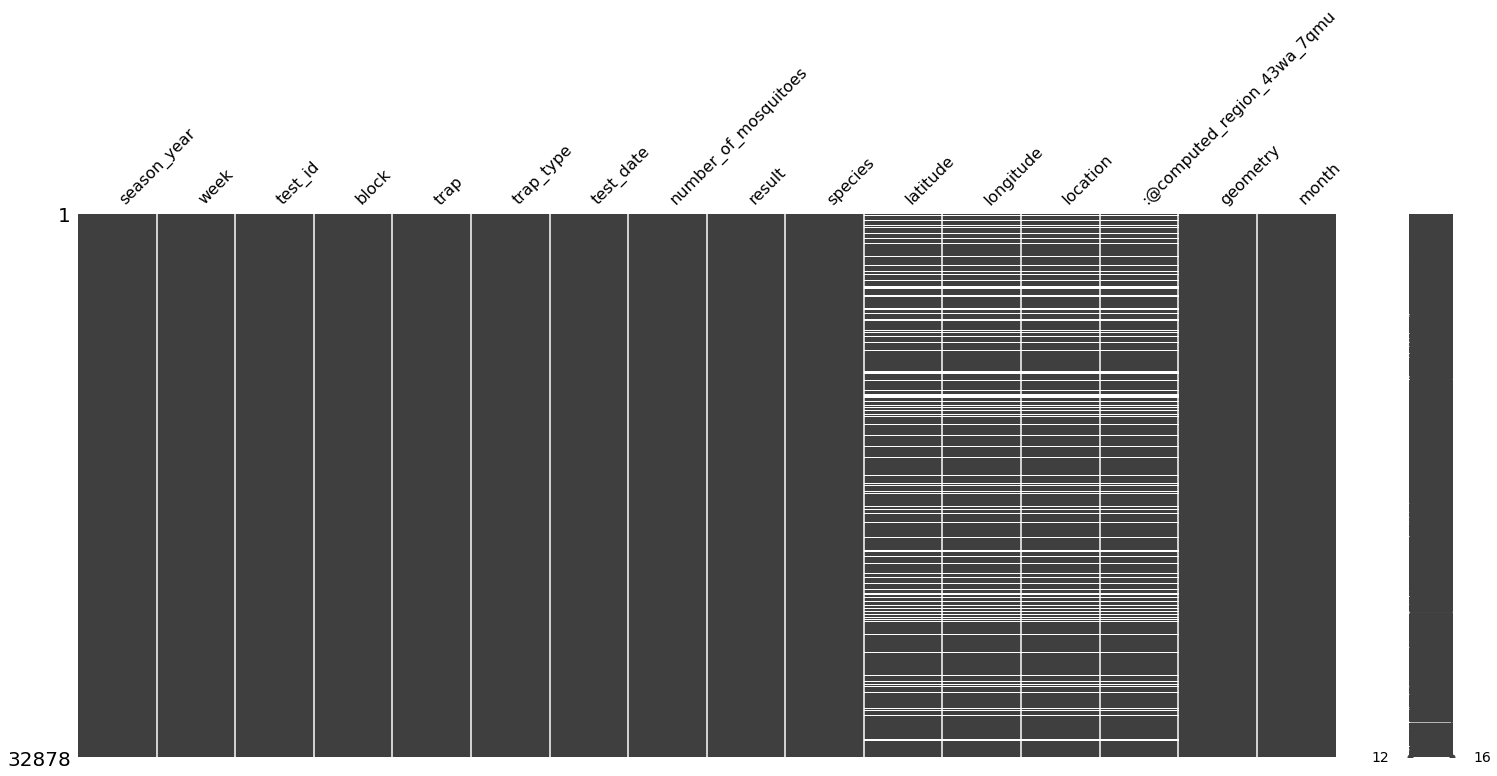

In [ ]:
# check NAs
msno.matrix(df_trap)


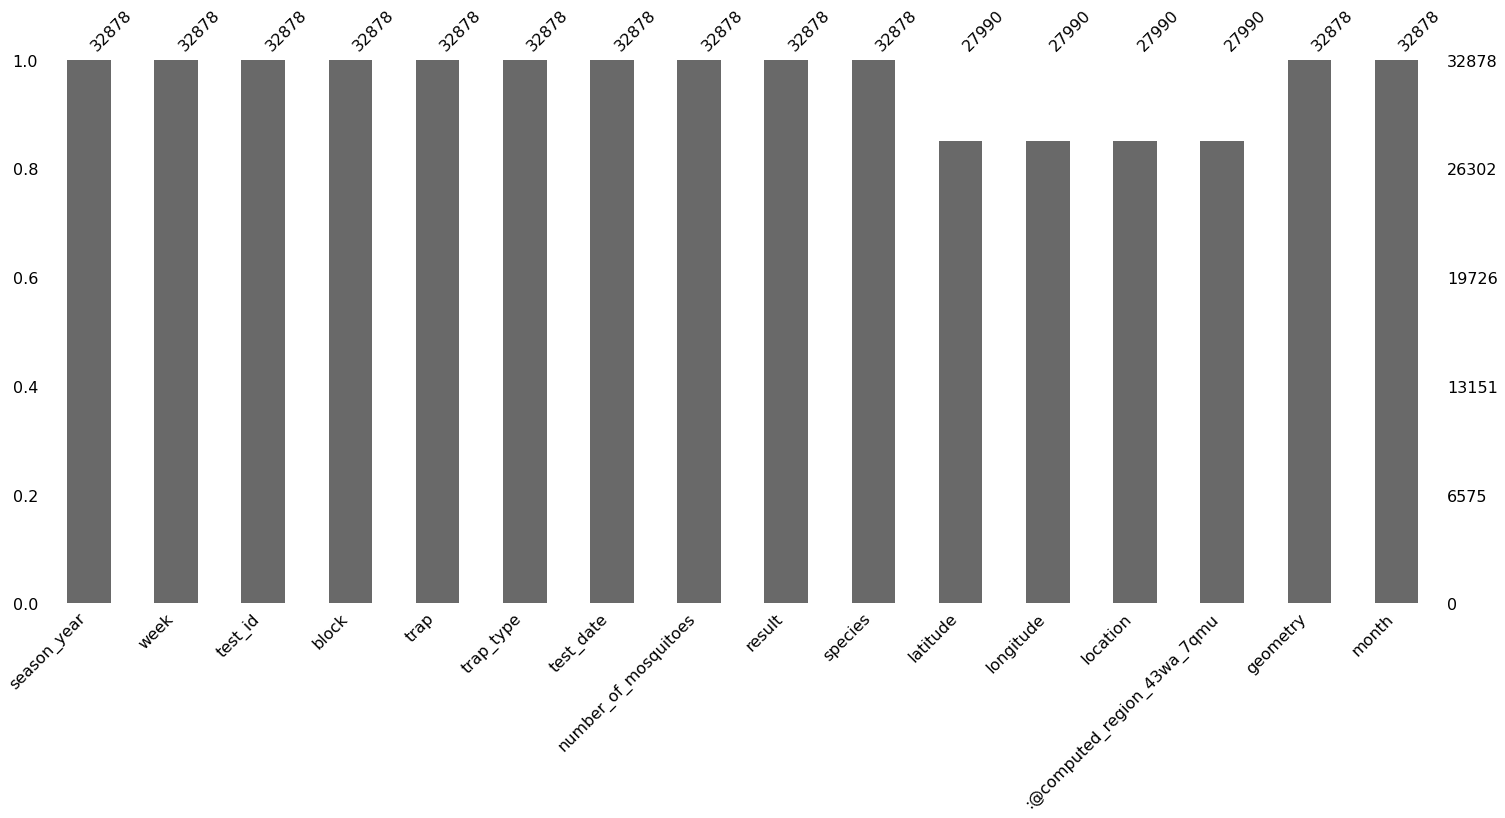

In [ ]:
msno.bar(df_trap)


In [ ]:
df_trap['result'].unique()

array(['negative', 'positive'], dtype=object)

In [ ]:
df_trap['result_b'] =  (df_trap['result'] == 'positive').astype('int')

In [ ]:
data_vis_1 = pd.DataFrame(df_trap.groupby(['season_year','trap'])['result_b'].sum()).reset_index()
data_vis_1

,season_year,trap,result_b
0,2007,T001,0
1,2007,T002,8
2,2007,T003,4
3,2007,T004,0
4,2007,T005,2
...,...,...,...
1330,2021,T909,19
1331,2021,T910,6
1332,2021,T912,1
1333,2021,T913,8


In [ ]:
# sns.barplot(x="season_year", y="result_b", data=data_vis_1,
#             hue='trap')

In [ ]:
df_trap.groupby('season_year').sum('number_of_mosquitoes')

,number_of_mosquitoes,latitude,longitude,month,result_b
season_year,,,,,
2007,57708,144809.370100,-303686.114682,30010,234
2008,24034,76685.872383,-160733.283860,16243,99
2009,21108,76845.102258,-161082.407840,16452,19
2010,21885,82503.757851,-172919.209049,18423,76
2011,18799,70369.492017,-147498.038165,15570,57
2012,36021,88730.903893,-185922.701268,18603,437
2013,36444,86150.560895,-180553.627993,18114,239
2014,37658,99886.246642,-209320.189637,20987,211
2015,16997,58455.383002,-122507.196139,13189,113


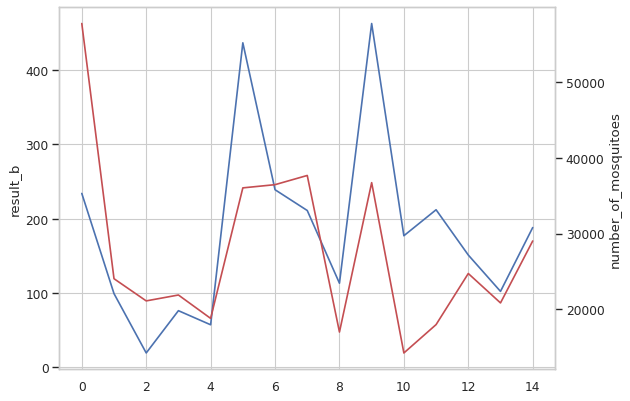

In [ ]:
p1 = df_trap.groupby('season_year').sum()[['result_b','number_of_mosquitoes']].reset_index()
fig = plt.figure(figsize=(8, 6), dpi=80)
sns.set_theme(style="whitegrid")

sns.lineplot(data=p1.result_b)
ax2 = plt.twinx()
ax2.grid(None)
sns.lineplot(data=p1.number_of_mosquitoes, color="r", ax=ax2)

In [ ]:
df_trap

,season_year,week,test_id,block,trap,trap_type,test_date,number_of_mosquitoes,result,species,latitude,longitude,location,:@computed_region_43wa_7qmu,geometry,month,result_b
0,2021,39,53373,12XX W GREENLEAF AVE,T018,GRAVID,2021-09-30 00:09:00,2,negative,CULEX PIPIENS/RESTUANS,42.010529,-87.660845,"{'latitude': '42.01052928915475', 'longitude':...",5,POINT (-87.66085 42.01053),9,0
1,2021,39,53381,61XX W FULLERTON AVE,T013,GRAVID,2021-09-30 00:09:00,13,negative,CULEX PIPIENS/RESTUANS,41.923887,-87.778910,"{'latitude': '41.92388736426867', 'longitude':...",21,POINT (-87.77891 41.92389),9,0
2,2021,39,53406,10XX E 67TH ST,T073,GRAVID,2021-09-30 00:09:00,7,negative,CULEX PIPIENS/RESTUANS,41.773085,-87.600168,"{'latitude': '41.773085401492715', 'longitude'...",33,POINT (-87.60017 41.77309),9,0
3,2021,39,53401,52XX W 63RD ST,T065,GRAVID,2021-09-30 00:09:00,8,negative,CULEX PIPIENS/RESTUANS,41.778305,-87.754366,"{'latitude': '41.77830515554422', 'longitude':...",6,POINT (-87.75437 41.77831),9,0
4,2021,39,53383,5XX S CENTRAL AVE,T031,GRAVID,2021-09-30 00:09:00,5,positive,CULEX PIPIENS/RESTUANS,41.872873,-87.764737,"{'latitude': '41.87287286249572', 'longitude':...",7,POINT (-87.76474 41.87287),9,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32873,2007,21,20012,75XX N OAKLEY AVE,T148,GRAVID,2007-05-29 00:05:00,1,negative,CULEX PIPIENS/RESTUANS,42.017801,-87.687601,"{'latitude': '42.0178008501155', 'longitude': ...",5,POINT (-87.68760 42.01780),5,0
32874,2007,21,20038,22XX W 113TH ST,T086,GRAVID,2007-05-29 00:05:00,1,negative,CULEX PIPIENS/RESTUANS,41.688171,-87.678252,"{'latitude': '41.688170589570205', 'longitude'...",42,POINT (-87.67825 41.68817),5,0
32875,2007,21,20051,2XX W 89TH ST,T096,CDC,2007-05-29 00:05:00,5,negative,CULEX RESTUANS,41.732428,-87.631056,"{'latitude': '41.73242806400838', 'longitude':...",13,POINT (-87.63106 41.73243),5,0
32876,2007,21,20031,22XX N CANNON DR,T054,GRAVID,2007-05-29 00:05:00,2,negative,CULEX PIPIENS/RESTUANS,41.922512,-87.632378,"{'latitude': '41.922512376871495', 'longitude'...",34,POINT (-87.63238 41.92251),5,0


In [ ]:
df_trap.groupby(['season_year','month']).sum()

number_of_mosquitoes      latitude      longitude  result_b
season_year month                                                             
2007        5                        40   1004.746399   -2104.544954         0
            6                       427   6700.934510  -14034.250846         0
            7                      7199  23087.228740  -48398.565637         6
            8                     40015  77721.878814 -163046.230768       200
            9                      8321  27929.161804  -58565.237675        26
...                                 ...           ...            ...       ...
2020        10                      139   1547.998092   -3244.370881         0
2021        6                      3533   9791.924422  -20520.827564         0
            7                     11244  17369.559951  -36394.311893        28
            8                      9680  15530.004930  -32534.223572       131
            9                      4555  12762.331685  -26743.560027        29

[67 rows x 4 columns]

Text(0.5, 1.0, 'Number of positive cases over month')

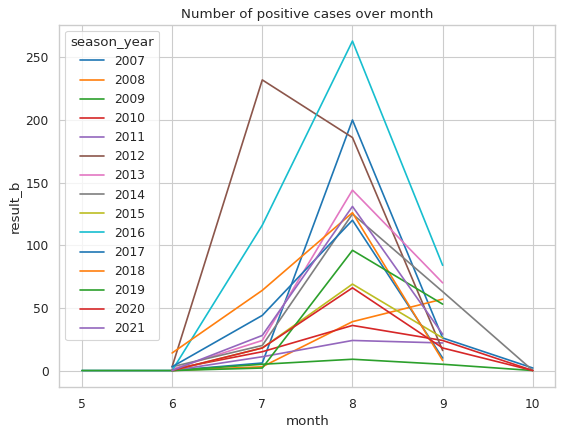

In [163]:
p2 = df_trap.groupby(['season_year','month']).sum()[['result_b','number_of_mosquitoes']].reset_index()
fig = plt.figure(figsize=(8, 6), dpi=80)

sns.lineplot(data=p2, x= 'month', y ='result_b',hue='season_year', palette='tab10')
plt.title('Number of positive cases over month')


Text(0.5, 1.0, 'Number of mosquitoes over month')

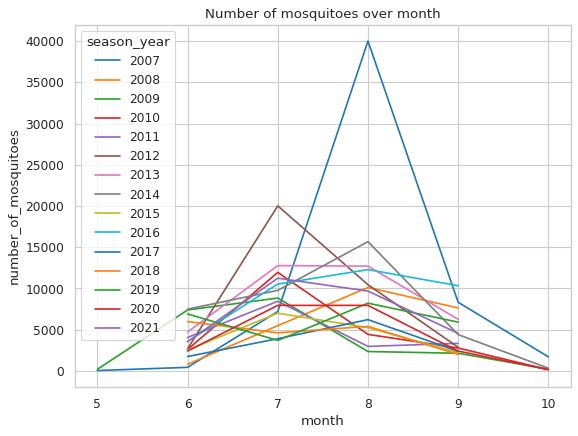

In [162]:
fig = plt.figure(figsize=(8, 6), dpi=80)

sns.lineplot(data=p2, x= 'month', y ='number_of_mosquitoes',hue='season_year', palette='tab10')
plt.title('Number of mosquitoes over month')


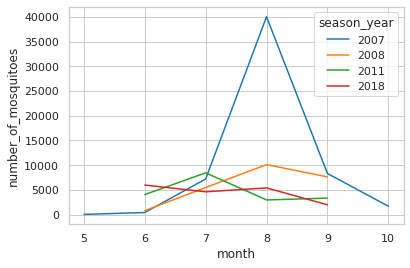

In [181]:
# These abnormal year shows abnormal in the heatmap below, but seems nothing exciting in lineplot
sns.lineplot(data=p2[(p2['season_year'] == 2007 ) | (p2['season_year'] ==  2008) | (p2['season_year'] ==  2011) | (p2['season_year'] ==  2018)], 
             x= 'month', y ='number_of_mosquitoes',hue='season_year', palette='tab10')



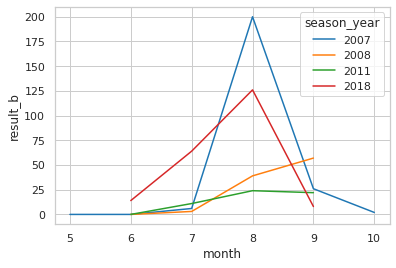

In [182]:

sns.lineplot(data=p2[(p2['season_year'] == 2007 ) | (p2['season_year'] ==  2008) | (p2['season_year'] ==  2011) | (p2['season_year'] ==  2018)], 
             x= 'month', y ='result_b',hue='season_year', palette='tab10')



In [ ]:

px.set_mapbox_access_token('pk.eyJ1IjoiZHJlYW0zciIsImEiOiJja3p0ZnZwem4xbjExMnZuYTNyNm05NXFkIn0.Mn-2ZucLu2QP-9nS1UZbKA')
fig = px.scatter_mapbox(data_frame = df_trap_raw, lat = 'latitude', lon  = 'longitude', 
                        size_max=15, zoom = 9.3)

fig.update_layout(title = 'Mosquito traps location in Chicago',
    autosize=False,
    width=600,
    height=700,)

fig.show()

In [ ]:
mosquitoN_and_result = pd.concat([
  df_trap.groupby(['trap','latitude','longitude'])['number_of_mosquitoes'].sum(),
  df_trap.groupby(['trap','latitude','longitude'])['result_b'].sum()],
  axis = 1
).reset_index()

In [ ]:
mosquitoN_and_result.head()

,trap,latitude,longitude,number_of_mosquitoes,result_b
0,220A,41.987054,-87.728398,116,2
1,T001,41.954282,-87.733843,25,0
2,T002,41.956299,-87.797517,16271,88
3,T002A,41.965414,-87.782119,178,0
4,T002B,41.951535,-87.789835,9,0


Size is total number of mosquitoes in each trap, color is total positive times in each trap

In [ ]:

plt.figure(figsize=(8, 6), dpi=80)
fig = px.scatter_mapbox(mosquitoN_and_result, lat = 'latitude', lon  = 'longitude', color = 'result_b',
                        size = 'number_of_mosquitoes', color_continuous_scale = px.colors.sequential.Viridis,
                        hover_data = ['number_of_mosquitoes', 'result_b'],
                       zoom = 9)
fig.update_layout(
    title="Total number of mosquitoes and positive times",
    width=500,
    height=700,
)

fig.show()

<Figure size 640x480 with 0 Axes>

spray data

In [ ]:
spray = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Capstone/data/spray.csv')

In [ ]:
spray.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       14835 non-null  object 
 1   Time       14251 non-null  object 
 2   Latitude   14835 non-null  float64
 3   Longitude  14835 non-null  float64
dtypes: float64(2), object(2)
memory usage: 463.7+ KB


In [ ]:
fig = px.scatter_mapbox(spray, lat = 'Latitude', lon  = 'Longitude',
                     animation_frame = 'Date',
                     zoom = 8)

fig.update_layout(
    title="Spray day-wise",
    width=500,
    height=700,
)

fig.show()

In [ ]:
forestry = gpd.read_file("/content/drive/MyDrive/Colab Notebooks/Capstone/data/Forestry/Forestry.shp")
park = gpd.read_file("/content/drive/MyDrive/Colab Notebooks/Capstone/data/Parks - Chicago Park District Park Boundaries (current).geojson")

In [ ]:
forestry.geometry.crs

<Projected CRS: EPSG:3435>
Name: NAD83 / Illinois East (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - Illinois - counties of Boone; Champaign; Clark; Clay; Coles; Cook; Crawford; Cumberland; De Kalb; De Witt; Douglas; Du Page; Edgar; Edwards; Effingham; Fayette; Ford; Franklin; Gallatin; Grundy; Hamilton; Hardin; Iroquois; Jasper; Jefferson; Johnson; Kane; Kankakee; Kendall; La Salle; Lake; Lawrence; Livingston; Macon; Marion; Massac; McHenry; McLean; Moultrie; Piatt; Pope; Richland; Saline; Shelby; Vermilion; Wabash; Wayne; White; Will; Williamson.
- bounds: (-89.28, 37.06, -87.02, 42.5)
Coordinate Operation:
- name: SPCS83 Illinois East zone (US Survey feet)
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [ ]:
forestry.head()

,AREA,PERIMETER,FOREST_,FOREST_ID,NAME,EDIT_DATE1,FID_,SHAPE_AREA,SHAPE_LEN,geometry
0,2.144996e+07,37340.04869,1,2,CATHRINE CHEVALIER WOODS,03-21-01,None,2.144996e+07,37340.064884,"MULTIPOLYGON (((1116598.400 1932500.000, 11165..."
1,1.878679e+07,48679.85682,2,8,SHILLER WOODS NORTH,03-21-01,None,1.878679e+07,48679.859013,"MULTIPOLYGON (((1115000.000 1927103.090, 11149..."
2,1.507464e+06,4878.06941,3,9,SHILLER PLAYFIELD,03-21-01,None,1.507464e+06,4878.068560,"POLYGON ((1120638.930 1926922.840, 1120632.440..."
3,2.405552e+07,27200.18266,4,3,SHILLER WOODS SOUTH,03-21-01,None,2.405551e+07,27200.178457,"MULTIPOLYGON (((1115000.000 1922223.430, 11150..."
4,5.991599e+06,16391.37539,5,10,SIDNEY YATES FLATWOODS,03-21-01,None,5.991605e+06,16391.364149,"POLYGON ((1135000.000 1942163.200, 1134922.100..."


In [ ]:
forestry = forestry.to_crs(park.crs)

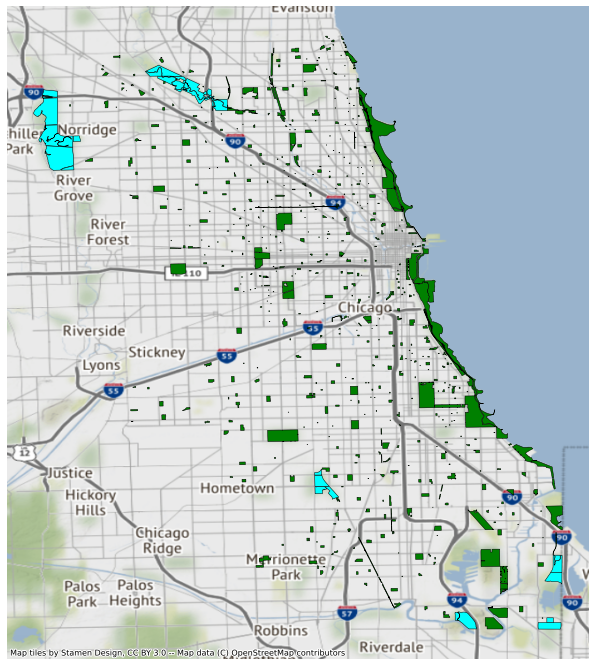

In [ ]:
!pip install contextily
import contextily as ctx
# create the axes
fig, ax = plt.subplots(figsize=(12, 12))

# Add the forestry and park
forestry.plot(ax=ax, edgecolor='black', linewidth=0.5, facecolor='cyan')
park.plot(ax=ax, edgecolor='black', linewidth=0.5, facecolor='green')

# NEW: plot the basemap underneath
ctx.add_basemap(ax=ax, crs=forestry.crs, source=ctx.providers.Stamen.Terrain)

# remove axis lines
ax.set_axis_off()

fig.show()

Weather

In [ ]:
weather = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Capstone/data/weather.csv')

In [ ]:
weather.columns

Index(['Station', 'Date', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint',
       'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset', 'CodeSum', 'Depth',
       'Water1', 'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel',
       'ResultSpeed', 'ResultDir', 'AvgSpeed'],
      dtype='object')


Trash 

street cleaning

flooding


In [ ]:
# make a kernal density map of both number of mosquitoes and wnv posivity

from sklearn.neighbors import KernelDensity

mapdata = np.loadtxt("/content/drive/MyDrive/Colab Notebooks/Capstone/data/mapdata_copyright_openstreetmap_contributors.txt")

def drawKDE(year, factor, subplot): 
  # factor = 'result_b' or factor = 'number_of_mosquitoes'
  # color is color of heatmap, blue or red
  if factor == 'result_b':
      alpha_cm = plt.cm.Blues;
  elif factor == 'number_of_mosquitoes':
      alpha_cm = plt.cm.Reds;

  alpha_cm._init()
  alpha_cm._lut[:-3,-1] = abs(np.logspace(0, 1, alpha_cm.N) / 10 - 1)[::-1]
  aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
  lon_lat_box = (-88, -87.5, 41.6, 42.1)

  if factor == 'result_b':
    sigthings = df_trap[(df_trap['result_b'] > 0) & (df_trap['season_year'] == year)]
    sigthings = sigthings.groupby(['week', 'trap','longitude', 'latitude']).max()[factor].reset_index()
    X = sigthings[['longitude', 'latitude']].values
    kd = KernelDensity(bandwidth=0.02)
    kd.fit(X);
    
  elif factor == 'number_of_mosquitoes':
    sigthings = df_trap[df_trap['season_year'] == year]
    sigthings = sigthings.groupby(['week', 'trap','longitude', 'latitude']).sum()[factor].reset_index()
    X = sigthings[['longitude', 'latitude']].values
    kd = KernelDensity(bandwidth=0.02)
    kd.fit(X,sample_weight = sigthings[factor]) # if not this line, kernal density only count frequency

  # kernal density diagram here
  xv,yv = np.meshgrid(np.linspace(-88, -87.5, 100), np.linspace(41.6, 42.1, 100))
  gridpoints = np.array([xv.ravel(),yv.ravel()]).T
  zv = np.exp(kd.score_samples(gridpoints).reshape(100,100))
  plt.subplot(subplot)
  plt.gca().set_title(year)
  plt.imshow(mapdata, 
            cmap=plt.get_cmap('gray'), 
            extent=lon_lat_box, 
            aspect=aspect)
  plt.imshow(zv, 
            origin='lower', 
            cmap=alpha_cm, 
            extent=lon_lat_box, 
            aspect=aspect)

# trap points
  locations = df_trap[['longitude', 'latitude']].drop_duplicates().values
  plt.scatter(locations[:,0], locations[:,1],s=1, marker='x',c="black")

  plt.savefig('heatmap.png')

In [ ]:
def ImgSet(a, b, factor):
  # a and b are the start and end year of data. Must be 7 years.
  # factor = 'result_b' or factor = 'number_of_mosquitoes'
  plt.figure(figsize=(18,6))

  for year,subplot in zip(np.arange(a,b,1), [181, 182, 183, 184,185,186,187,188]):
    drawKDE(year,factor, subplot)

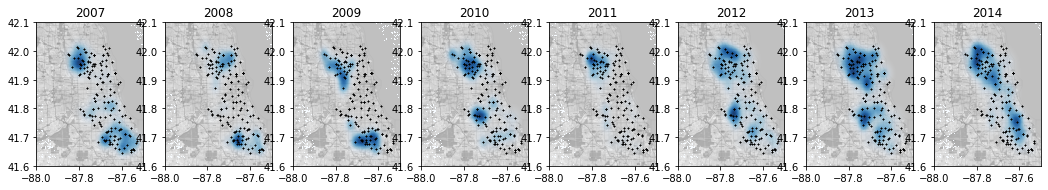

In [ ]:
ImgSet(2007,2015,'result_b')

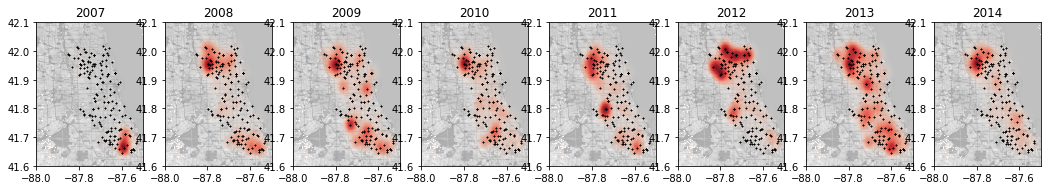

In [ ]:
ImgSet(2007,2015,'number_of_mosquitoes')

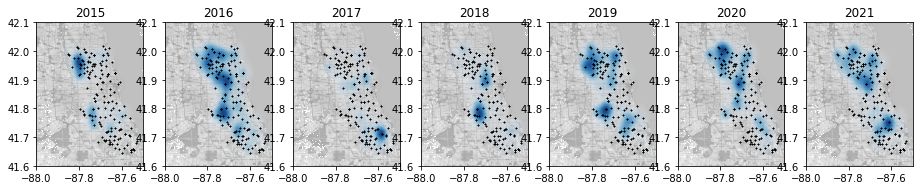

In [ ]:
ImgSet(2015,2022,'result_b')

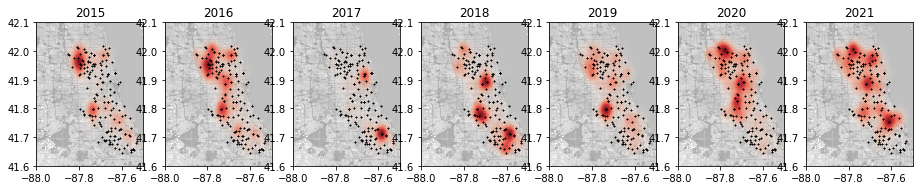

In [ ]:
ImgSet(2015,2022,'number_of_mosquitoes')

Notes Mar 4:

Get down to one year data that spray has

Different before & after spray

Spatial relationship to parks and waters

In [ ]:
df_trap.test_date.drop_duplicates()

0        2021-09-30T00:09:00.000
65       2021-09-23T00:09:00.000
129      2021-09-16T00:09:00.000
214      2021-09-09T00:09:00.000
257      2021-09-02T00:09:00.000
                  ...           
32773    2007-06-26T04:06:08.000
32774    2007-06-26T04:06:07.000
32784    2007-06-26T04:06:06.000
32794    2007-06-05T00:06:00.000
32853    2007-05-29T00:05:00.000
Name: test_date, Length: 336, dtype: object

In [ ]:
Classnote 
git rid of spatial auto correlation
simultaneous auto regression SAR and 